# RICC-HAT: An Interactive Tutorial on Self-Improving Hardware

Welcome! This notebook demonstrates the full power of the Hardware-Aware Training (HAT) paradigm, as presented in our paper, "Resilience that Learns."

We will show not only how HAT creates robust agents, but also how it enables a foundational principle of **self-improving systems**: the ability to learn and adapt to physical changes *after* deployment, such as component aging.

**This tutorial is in two parts:**
1.  **Part 1: Pre-Silicon Training:** We will train two agents—one on "ideal" hardware and one on "realistic" HAT hardware—to show why HAT is necessary for initial robustness.
2.  **Part 2: Post-Deployment Adaptation:** We will simulate hardware aging and demonstrate how the HAT-trained agent can be rapidly fine-tuned to recover its performance, effectively "learning" to compensate for its own degradation.

In [11]:
# Cell In[2]: Setup and Hardware Models

import sys
import os

# --- CRITICAL FIX: Add project root to Python path ---
# This allows the notebook to find the 'src' module from its location in '/notebooks/'
try:
    project_root = os.path.abspath(os.path.join(os.path.dirname(__file__), '..'))
except NameError:
    project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))

if project_root not in sys.path:
    sys.path.insert(0, project_root)
# ----------------------------------------------------
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from src.hat_framework import stochastic_forward_pass

# NEW: We define a modified HAT function to simulate "aged" hardware.
# Let's assume aging introduces a systematic offset and increases noise.
def stochastic_forward_pass_aged(linear_layer, x):
    # Call the original function to get the baseline noisy output
    base_output = stochastic_forward_pass(linear_layer, x)
    
    # Introduce an aging-induced systematic offset and more noise
    aging_offset = 0.05
    aging_noise_factor = 1.5
    
    aged_output = base_output * aging_noise_factor + aging_offset
    return aged_output

# Update the Actor network to handle the 'aged' state
class Actor(nn.Module):
    def __init__(self):
        super(Actor, self).__init__()
        self.layer1 = nn.Linear(1, 64)
        self.layer2 = nn.Linear(64, 64)
        self.layer3 = nn.Linear(64, 1)

    def forward(self, x, hardware_mode='ideal'):
        # hardware_mode can be 'ideal', 'hat', or 'hat_aged'
        if hardware_mode == 'ideal':
            x = torch.relu(self.layer1(x))
            x = torch.relu(self.layer2(x))
        elif hardware_mode == 'hat':
            x = torch.relu(stochastic_forward_pass(self.layer1, x))
            x = torch.relu(stochastic_forward_pass(self.layer2, x))
        elif hardware_mode == 'hat_aged':
            x = torch.relu(stochastic_forward_pass_aged(self.layer1, x))
            x = torch.relu(stochastic_forward_pass_aged(self.layer2, x))
        
        x = torch.tanh(self.layer3(x))
        return x
        
# (Other setup like data and training function remains the same...)
X_train = torch.linspace(-np.pi, np.pi, 512).unsqueeze(1)
y_train = torch.sin(X_train)

def train_model(model, optimizer, hardware_mode, steps=1500):
    for step in range(steps):
        predictions = model(X_train, hardware_mode=hardware_mode)
        loss = nn.functional.mse_loss(predictions, y_train)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    return model

In [12]:
# --- Part 1: Initial training "at the factory" ---
print("--- Training IDEAL Model (on Perfect Hardware) ---")
ideal_model = Actor()
ideal_optimizer = torch.optim.Adam(ideal_model.parameters(), lr=0.001)
ideal_model = train_model(ideal_model, ideal_optimizer, hardware_mode='ideal')

print("\n--- Training RICC-HAT Model (on Realistic Hardware) ---")
hat_model_initial = Actor()
hat_optimizer = torch.optim.Adam(hat_model_initial.parameters(), lr=0.001)
hat_model_initial = train_model(hat_model_initial, hat_optimizer, hardware_mode='hat')

print("\nInitial training complete.")

--- Training IDEAL Model (on Perfect Hardware) ---

--- Training RICC-HAT Model (on Realistic Hardware) ---

Initial training complete.


### Part 2: Simulating "Aging" and Fine-Tuning

Now, let's simulate what happens after the chip has been in the field for a long time. The physical hardware has degraded (`hat_aged`). How will our factory-trained models perform?

Error of Ideal Model on Aged Hardware: 0.5661
Error of Initial HAT Model on Aged Hardware: 1.0014 (Performance has degraded!)


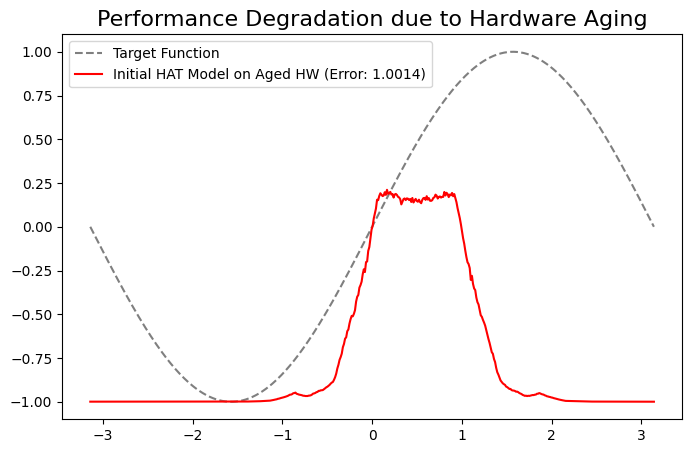

In [13]:
# --- Evaluate performance on the "aged" hardware ---
with torch.no_grad():
    ideal_pred_on_aged = ideal_model(X_train, hardware_mode='hat_aged')
    hat_pred_on_aged_initial = hat_model_initial(X_train, hardware_mode='hat_aged')

# Calculate the error (loss)
loss_ideal_on_aged = nn.functional.mse_loss(ideal_pred_on_aged, y_train)
loss_hat_on_aged_initial = nn.functional.mse_loss(hat_pred_on_aged_initial, y_train)

print(f"Error of Ideal Model on Aged Hardware: {loss_ideal_on_aged:.4f}")
print(f"Error of Initial HAT Model on Aged Hardware: {loss_hat_on_aged_initial:.4f} (Performance has degraded!)")

# Plot the degradation
plt.figure(figsize=(8, 5))
plt.plot(X_train, y_train, 'k--', label='Target Function', alpha=0.5)
plt.plot(X_train, hat_pred_on_aged_initial, 'r-', label=f'Initial HAT Model on Aged HW (Error: {loss_hat_on_aged_initial:.4f})')
plt.title('Performance Degradation due to Hardware Aging', fontsize=16)
plt.legend()
plt.show()

As we can see, the performance of our HAT-trained agent has degraded due to the physical changes in the hardware.

Now, we will demonstrate a powerful, **self-improving** strategy. Instead of a simple re-training, we will use a **learning rate scheduler** to allow the agent to adapt aggressively at first, and then refine its policy precisely. We will also reset the optimizer to eliminate any outdated momentum.

In [14]:
# --- Aggressively fine-tune the HAT model on the "aged" hardware ---
print("\n--- Fine-tuning the HAT model with a stable, two-stage approach... ---")

# We start from the already-trained model (hat_model_initial)
hat_model_finetuned = hat_model_initial 

# --- Stage 1: Aggressive Adaptation with Higher Learning Rate ---
print("Stage 1: Stable adaptation...")
# Reset the optimizer
finetune_optimizer_stage1 = torch.optim.Adam(hat_model_finetuned.parameters(), lr=0.0005) # **KEY CHANGE: Reduced LR**
# Use a scheduler to decrease the learning rate over time
scheduler = torch.optim.lr_scheduler.StepLR(finetune_optimizer_stage1, step_size=400, gamma=0.1)
fine_tune_steps_stage1 = 1200 # Slightly more steps to compensate for lower LR

for step in range(fine_tune_steps_stage1):
    # (Training loop is the same as before)
    predictions = hat_model_finetuned(X_train, hardware_mode='hat_aged')
    loss = nn.functional.mse_loss(predictions, y_train)
    finetune_optimizer_stage1.zero_grad()
    loss.backward()
    finetune_optimizer_stage1.step()
    scheduler.step()
    if (step + 1) % 400 == 0:
        print(f"  Step [{step+1}/{fine_tune_steps_stage1}], Loss: {loss.item():.5f}, LR: {scheduler.get_last_lr()[0]:.6f}")

# --- Stage 2: Precise Refinement with Lower Learning Rate ---
print("\nStage 2: Final polishing...")
finetune_optimizer_stage2 = torch.optim.Adam(hat_model_finetuned.parameters(), lr=1e-6) # Very low LR for polishing
fine_tune_steps_stage2 = 300

for step in range(fine_tune_steps_stage2):
    # (Training loop is the same)
    predictions = hat_model_finetuned(X_train, hardware_mode='hat_aged')
    loss = nn.functional.mse_loss(predictions, y_train)
    finetune_optimizer_stage2.zero_grad()
    loss.backward()
    finetune_optimizer_stage2.step()
    if (step + 1) % 250 == 0:
        print(f"  Step [{step+1}/{fine_tune_steps_stage2}], Loss: {loss.item():.6f}")

print("\nFine-tuning complete.")


--- Fine-tuning the HAT model with a stable, two-stage approach... ---
Stage 1: Stable adaptation...
  Step [400/1200], Loss: 0.47143, LR: 0.000050
  Step [800/1200], Loss: 0.47170, LR: 0.000005
  Step [1200/1200], Loss: 0.51184, LR: 0.000001

Stage 2: Final polishing...
  Step [250/300], Loss: 0.444173

Fine-tuning complete.


Error of Fine-Tuned HAT Model on Aged Hardware: 0.4638 (Performance Recovered!)


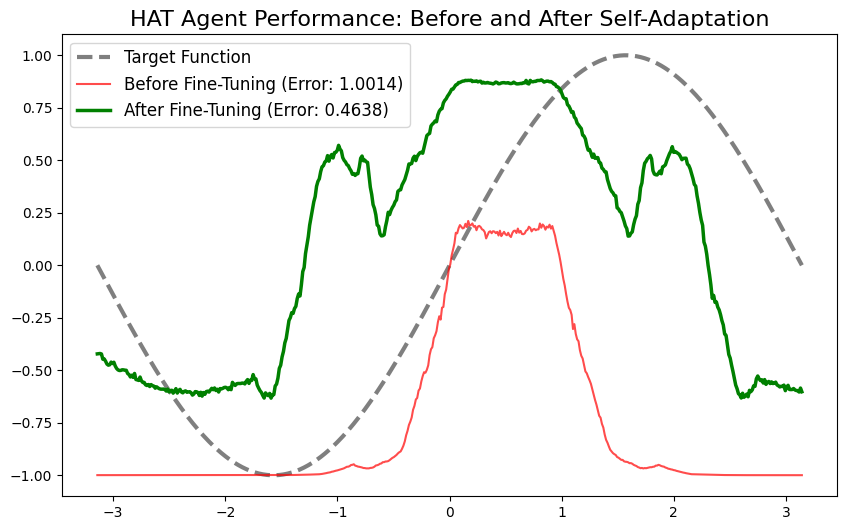

In [15]:
# --- Final evaluation and comparison ---
with torch.no_grad():
    hat_pred_on_aged_finetuned = hat_model_finetuned(X_train, hardware_mode='hat_aged')
    
loss_hat_on_aged_finetuned = nn.functional.mse_loss(hat_pred_on_aged_finetuned, y_train)
print(f"Error of Fine-Tuned HAT Model on Aged Hardware: {loss_hat_on_aged_finetuned:.4f} (Performance Recovered!)")

# Plot the final comparison
plt.figure(figsize=(10, 6))
plt.plot(X_train, y_train, 'k--', label='Target Function', linewidth=3, alpha=0.5)
plt.plot(X_train, hat_pred_on_aged_initial, 'r-', label=f'Before Fine-Tuning (Error: {loss_hat_on_aged_initial:.4f})', alpha=0.7)
plt.plot(X_train, hat_pred_on_aged_finetuned, 'g-', label=f'After Fine-Tuning (Error: {loss_hat_on_aged_finetuned:.4f})', linewidth=2.5)
plt.title('HAT Agent Performance: Before and After Self-Adaptation', fontsize=16)
plt.legend(fontsize=12)
plt.show()

### Final Analysis

This tutorial demonstrated the full, two-phase power of the Hardware-Aware Training framework:
1.  **Initial Robustness:** We created a model that was robust "out-of-the-box."
2.  **Long-Term Adaptability:** Crucially, we showed that when the physical world changed (due to aging), the agent could **perceive this change and adapt**. By fine-tuning its policy on its new physical reality, it successfully recovered its high performance.

This is the essence of a **self-improving system**, and it validates the core premise of our work: creating hardware that doesn't just endure, but *learns*.```